# Training Session
This section tries to do the following tasks:
* Train a classification model on your system
* Convert the Trained model into Keras
* Convert the Trained model into ONNX

#### Import required libraries

In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr

2022-12-25 20:11:47.250390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Check data

In [2]:
data_dir = "./data"
image_exts = ['jpg', 'jpeg', 'bmp', 'png']

#### The following Cell detect images with wrong extentions. These images could make problems during training the network. 

There is a file created by Mac called .DS_Store. Next cell will check each file and ignore it whenever it sees it.

In [3]:
# Go to the data directory
for image_class in os.listdir(data_dir): 
    if image_class == '.DS_Store':
        continue
    # Enter images directories
    for image in os.listdir(os.path.join(data_dir, image_class)):
        if image == '.DS_Store':
            continue
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile


#### Next step is to load data for training

In [4]:
data = tf.keras.utils.image_dataset_from_directory('data')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 251 files belonging to 2 classes.


2022-12-25 20:12:54.091767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 20:12:54.999812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


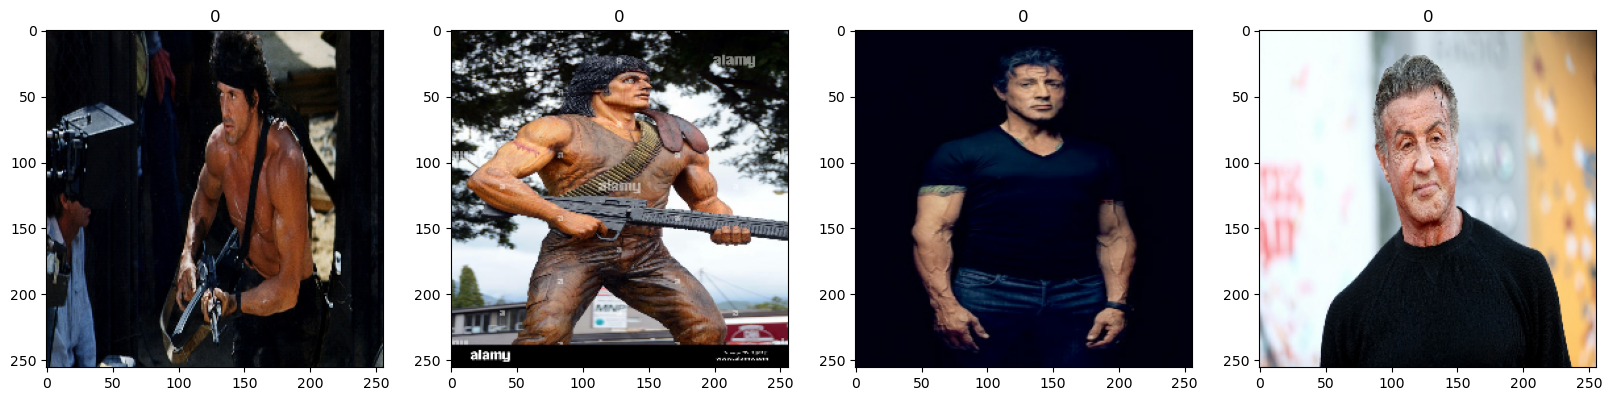

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#### Scale and Split Data

In [6]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
train_size = int(len(data)*.5)
val_size = int(len(data)*.3)
test_size = int(len(data)*.2)
print("Train size", train_size)
print("Validation", val_size)
print("Test size", test_size)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-25 20:12:58.844868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Train size 4
Validation 2
Test size 1


#### Build deep learning model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras import activations

model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3)))
model.add(BatchNormalization())
model.add(Activation(activations.relu))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.summary()

#### Training

In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/100


2022-12-25 20:13:06.860667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.9507 - accuracy: 0.4922

2022-12-25 20:13:12.713273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 10s 2s/step - loss: 0.9507 - accuracy: 0.4922 - val_loss: 0.6756 - val_accuracy: 0.6250
Epoch 2/100


2022-12-25 20:13:15.616852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.5859

2022-12-25 20:13:21.353185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.7444 - accuracy: 0.5859 - val_loss: 0.6821 - val_accuracy: 0.5312
Epoch 3/100


2022-12-25 20:13:24.159327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7031

2022-12-25 20:13:29.781718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.5655 - accuracy: 0.7031 - val_loss: 0.6910 - val_accuracy: 0.4688
Epoch 4/100


2022-12-25 20:13:32.627871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.6719

2022-12-25 20:13:38.563523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.5570 - accuracy: 0.6719 - val_loss: 0.6831 - val_accuracy: 0.5781
Epoch 5/100


2022-12-25 20:13:41.800096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8047

2022-12-25 20:13:47.516668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.4172 - accuracy: 0.8047 - val_loss: 0.6689 - val_accuracy: 0.6250
Epoch 6/100


2022-12-25 20:13:50.197866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8438

2022-12-25 20:13:56.428761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.3391 - accuracy: 0.8438 - val_loss: 0.6730 - val_accuracy: 0.6875
Epoch 7/100


2022-12-25 20:13:59.332881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8828

2022-12-25 20:14:04.908679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.2992 - accuracy: 0.8828 - val_loss: 0.6754 - val_accuracy: 0.6719
Epoch 8/100


2022-12-25 20:14:07.601437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8750

2022-12-25 20:14:13.218004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.3088 - accuracy: 0.8750 - val_loss: 0.6767 - val_accuracy: 0.7031
Epoch 9/100


2022-12-25 20:14:15.997800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9375

2022-12-25 20:14:21.804296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.2368 - accuracy: 0.9375 - val_loss: 0.6757 - val_accuracy: 0.6562
Epoch 10/100


2022-12-25 20:14:24.697075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9531

2022-12-25 20:14:30.924554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.2054 - accuracy: 0.9531 - val_loss: 0.6858 - val_accuracy: 0.5938
Epoch 11/100


2022-12-25 20:14:34.183634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9844

2022-12-25 20:14:40.894022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 10s 2s/step - loss: 0.1448 - accuracy: 0.9844 - val_loss: 0.6866 - val_accuracy: 0.5469
Epoch 12/100


2022-12-25 20:14:43.982896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9844

2022-12-25 20:14:49.856909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.1316 - accuracy: 0.9844 - val_loss: 0.7298 - val_accuracy: 0.3750
Epoch 13/100


2022-12-25 20:14:52.431505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9688

2022-12-25 20:14:57.721641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.1198 - accuracy: 0.9688 - val_loss: 0.6918 - val_accuracy: 0.5312
Epoch 14/100


2022-12-25 20:15:00.451702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9844

2022-12-25 20:15:06.465592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0844 - accuracy: 0.9844 - val_loss: 0.6928 - val_accuracy: 0.4844
Epoch 15/100


2022-12-25 20:15:09.436262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9844

2022-12-25 20:15:15.604614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0866 - accuracy: 0.9844 - val_loss: 0.6818 - val_accuracy: 0.6094
Epoch 16/100


2022-12-25 20:15:18.357971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 1.0000

2022-12-25 20:15:24.466834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0518 - accuracy: 1.0000 - val_loss: 0.7031 - val_accuracy: 0.4844
Epoch 17/100


2022-12-25 20:15:27.219920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 1.0000

2022-12-25 20:15:32.992498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0475 - accuracy: 1.0000 - val_loss: 0.7448 - val_accuracy: 0.4219
Epoch 18/100


2022-12-25 20:15:35.759082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 1.0000

2022-12-25 20:15:41.306960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.6958 - val_accuracy: 0.5312
Epoch 19/100


2022-12-25 20:15:44.015752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 1.0000

2022-12-25 20:15:49.556524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.6564 - val_accuracy: 0.6250
Epoch 20/100


2022-12-25 20:15:52.248758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9922

2022-12-25 20:15:57.802233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0352 - accuracy: 0.9922 - val_loss: 0.6721 - val_accuracy: 0.5625
Epoch 21/100


2022-12-25 20:16:00.507881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 1.0000

2022-12-25 20:16:06.137395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 0.6699 - val_accuracy: 0.6250
Epoch 22/100


2022-12-25 20:16:08.900235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 1.0000

2022-12-25 20:16:14.464921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.6949 - val_accuracy: 0.6094
Epoch 23/100


2022-12-25 20:16:17.148987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 1.0000

2022-12-25 20:16:22.476421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.7034 - val_accuracy: 0.5000
Epoch 24/100


2022-12-25 20:16:25.019884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 1.0000

2022-12-25 20:16:30.402516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.6741 - val_accuracy: 0.5312
Epoch 25/100


2022-12-25 20:16:33.054113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 1.0000

2022-12-25 20:16:38.596131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.6674 - val_accuracy: 0.5625
Epoch 26/100


2022-12-25 20:16:41.307929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 1.0000

2022-12-25 20:16:46.865956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.6487 - val_accuracy: 0.6562
Epoch 27/100


2022-12-25 20:16:49.603514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 1.0000

2022-12-25 20:16:55.121359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.6549 - val_accuracy: 0.6406
Epoch 28/100


2022-12-25 20:16:57.795337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 1.0000

2022-12-25 20:17:03.128937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.6412 - val_accuracy: 0.6406
Epoch 29/100


2022-12-25 20:17:05.739805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

2022-12-25 20:17:11.099115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.6818 - val_accuracy: 0.5625
Epoch 30/100


2022-12-25 20:17:13.807147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

2022-12-25 20:17:19.413017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.5312
Epoch 31/100


2022-12-25 20:17:22.188461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

2022-12-25 20:17:27.800285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.6486 - val_accuracy: 0.6406
Epoch 32/100


2022-12-25 20:17:30.515278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

2022-12-25 20:17:36.110233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.5699 - val_accuracy: 0.7500
Epoch 33/100


2022-12-25 20:17:39.269503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

2022-12-25 20:17:44.885961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.5947 - val_accuracy: 0.7188
Epoch 34/100


2022-12-25 20:17:47.617239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 1.0000

2022-12-25 20:17:53.309049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.6247 - val_accuracy: 0.7188
Epoch 35/100


2022-12-25 20:17:56.096088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

2022-12-25 20:18:01.751521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.6117 - val_accuracy: 0.6406
Epoch 36/100


2022-12-25 20:18:04.447947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

2022-12-25 20:18:09.712686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.5490 - val_accuracy: 0.7812
Epoch 37/100


2022-12-25 20:18:12.394026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

2022-12-25 20:18:17.735552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.5389 - val_accuracy: 0.7500
Epoch 38/100


2022-12-25 20:18:20.307289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

2022-12-25 20:18:25.604872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5629 - val_accuracy: 0.6875
Epoch 39/100


2022-12-25 20:18:28.107492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

2022-12-25 20:18:33.318201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.5632 - val_accuracy: 0.7500
Epoch 40/100


2022-12-25 20:18:35.829739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

2022-12-25 20:18:41.023051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.5788 - val_accuracy: 0.7500
Epoch 41/100


2022-12-25 20:18:43.506348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

2022-12-25 20:18:48.664752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.5413 - val_accuracy: 0.7031
Epoch 42/100


2022-12-25 20:18:51.142777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

2022-12-25 20:18:56.268644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5659 - val_accuracy: 0.6719
Epoch 43/100


2022-12-25 20:18:58.753653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

2022-12-25 20:19:03.889418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4851 - val_accuracy: 0.8125
Epoch 44/100


2022-12-25 20:19:06.368369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

2022-12-25 20:19:11.575302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5567 - val_accuracy: 0.7188
Epoch 45/100


2022-12-25 20:19:14.079797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

2022-12-25 20:19:19.229501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4791 - val_accuracy: 0.8125
Epoch 46/100


2022-12-25 20:19:21.703315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

2022-12-25 20:19:27.237946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4905 - val_accuracy: 0.7812
Epoch 47/100


2022-12-25 20:19:29.736621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

2022-12-25 20:19:34.825009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.5690 - val_accuracy: 0.7031
Epoch 48/100


2022-12-25 20:19:37.326403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

2022-12-25 20:19:42.469970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4863 - val_accuracy: 0.7656
Epoch 49/100


2022-12-25 20:19:44.918691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000   

2022-12-25 20:41:49.356037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 1327s 441s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5329 - val_accuracy: 0.7344
Epoch 50/100


2022-12-25 20:41:52.465806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

2022-12-25 20:41:58.419712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4468 - val_accuracy: 0.7969
Epoch 51/100


2022-12-25 20:42:01.153587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

2022-12-25 20:42:07.151365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4993 - val_accuracy: 0.7656
Epoch 52/100


2022-12-25 20:42:09.793377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

2022-12-25 20:42:15.678837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4691 - val_accuracy: 0.8281
Epoch 53/100


2022-12-25 20:42:18.249248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

2022-12-25 20:42:23.693658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4400 - val_accuracy: 0.8125
Epoch 54/100


2022-12-25 20:42:26.399033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

2022-12-25 20:42:31.788700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3411 - val_accuracy: 0.9062
Epoch 55/100


2022-12-25 20:42:34.288531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 9.7568e-04 - accuracy: 1.0000

2022-12-25 20:42:39.553761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 9.7568e-04 - accuracy: 1.0000 - val_loss: 0.4088 - val_accuracy: 0.8281
Epoch 56/100


2022-12-25 20:42:42.059664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000  

2022-12-25 20:42:47.283572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4157 - val_accuracy: 0.8594
Epoch 57/100


2022-12-25 20:42:49.773996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

2022-12-25 20:42:54.973302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3991 - val_accuracy: 0.8594
Epoch 58/100


2022-12-25 20:42:57.479305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

2022-12-25 20:43:02.677147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3773 - val_accuracy: 0.8594
Epoch 59/100


2022-12-25 20:43:05.425932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 9.2598e-04 - accuracy: 1.0000

2022-12-25 20:43:10.681179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 9.2598e-04 - accuracy: 1.0000 - val_loss: 0.3805 - val_accuracy: 0.8906
Epoch 60/100


2022-12-25 20:43:13.275985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 8.4473e-04 - accuracy: 1.0000

2022-12-25 20:43:18.529484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 8.4473e-04 - accuracy: 1.0000 - val_loss: 0.3559 - val_accuracy: 0.8594
Epoch 61/100


2022-12-25 20:43:21.020614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 9.9787e-04 - accuracy: 1.0000

2022-12-25 20:43:26.266425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 9.9787e-04 - accuracy: 1.0000 - val_loss: 0.3991 - val_accuracy: 0.8125
Epoch 62/100


2022-12-25 20:43:28.768379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 8.7510e-04 - accuracy: 1.0000

2022-12-25 20:43:33.984036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 8.7510e-04 - accuracy: 1.0000 - val_loss: 0.3301 - val_accuracy: 0.8750
Epoch 63/100


2022-12-25 20:43:36.467246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000  

2022-12-25 20:43:41.683674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3954 - val_accuracy: 0.8125
Epoch 64/100


2022-12-25 20:43:44.185871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 8.0829e-04 - accuracy: 1.0000

2022-12-25 20:43:49.341672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 8.0829e-04 - accuracy: 1.0000 - val_loss: 0.2902 - val_accuracy: 0.8594
Epoch 65/100


2022-12-25 20:43:52.047570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 6.5874e-04 - accuracy: 1.0000

2022-12-25 20:43:57.658937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 6.5874e-04 - accuracy: 1.0000 - val_loss: 0.2796 - val_accuracy: 0.9062
Epoch 66/100


2022-12-25 20:44:00.155385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 6.7795e-04 - accuracy: 1.0000

2022-12-25 20:44:05.352775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 6.7795e-04 - accuracy: 1.0000 - val_loss: 0.2765 - val_accuracy: 0.9062
Epoch 67/100


2022-12-25 20:44:07.839478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 7.4097e-04 - accuracy: 1.0000

2022-12-25 20:44:13.075105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 7.4097e-04 - accuracy: 1.0000 - val_loss: 0.2320 - val_accuracy: 0.9219
Epoch 68/100


2022-12-25 20:44:15.557671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 4.9508e-04 - accuracy: 1.0000

2022-12-25 20:44:20.764539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 4.9508e-04 - accuracy: 1.0000 - val_loss: 0.2380 - val_accuracy: 0.9375
Epoch 69/100


2022-12-25 20:44:23.256885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 6.0836e-04 - accuracy: 1.0000

2022-12-25 20:44:28.519102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 6.0836e-04 - accuracy: 1.0000 - val_loss: 0.1984 - val_accuracy: 0.9531
Epoch 70/100


2022-12-25 20:44:31.015453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 6.2629e-04 - accuracy: 1.0000

2022-12-25 20:44:36.255414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 6.2629e-04 - accuracy: 1.0000 - val_loss: 0.2228 - val_accuracy: 0.9375
Epoch 71/100


2022-12-25 20:44:38.768650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 7.3005e-04 - accuracy: 1.0000

2022-12-25 20:44:44.505644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 7.3005e-04 - accuracy: 1.0000 - val_loss: 0.1673 - val_accuracy: 0.9375
Epoch 72/100


2022-12-25 20:44:47.033487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 6.5378e-04 - accuracy: 1.0000

2022-12-25 20:44:52.363478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 6.5378e-04 - accuracy: 1.0000 - val_loss: 0.2119 - val_accuracy: 0.9688
Epoch 73/100


2022-12-25 20:44:54.932308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

2022-12-25 20:45:00.809845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 9s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1733 - val_accuracy: 0.9375
Epoch 74/100


2022-12-25 20:45:03.490669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000    

2022-12-25 20:45:08.715974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2065 - val_accuracy: 0.9688
Epoch 75/100


2022-12-25 20:45:11.242493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 8.8254e-04 - accuracy: 1.0000

2022-12-25 20:45:16.500356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 8.8254e-04 - accuracy: 1.0000 - val_loss: 0.1477 - val_accuracy: 0.9531
Epoch 76/100


2022-12-25 20:45:19.005771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 5.9389e-04 - accuracy: 1.0000

2022-12-25 20:45:24.241433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 5.9389e-04 - accuracy: 1.0000 - val_loss: 0.1831 - val_accuracy: 0.9375
Epoch 77/100


2022-12-25 20:45:26.745152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 4.1737e-04 - accuracy: 1.0000

2022-12-25 20:45:31.954137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 4.1737e-04 - accuracy: 1.0000 - val_loss: 0.1175 - val_accuracy: 0.9844
Epoch 78/100


2022-12-25 20:45:34.462049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 6.0566e-04 - accuracy: 1.0000

2022-12-25 20:45:39.692603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 6.0566e-04 - accuracy: 1.0000 - val_loss: 0.1103 - val_accuracy: 1.0000
Epoch 79/100


2022-12-25 20:45:42.205464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 5.1833e-04 - accuracy: 1.0000

2022-12-25 20:45:47.451485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 5.1833e-04 - accuracy: 1.0000 - val_loss: 0.1320 - val_accuracy: 0.9844
Epoch 80/100


2022-12-25 20:45:49.936084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.8004e-04 - accuracy: 1.0000

2022-12-25 20:45:55.141349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.8004e-04 - accuracy: 1.0000 - val_loss: 0.1286 - val_accuracy: 0.9531
Epoch 81/100


2022-12-25 20:45:57.620781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.8733e-04 - accuracy: 1.0000

2022-12-25 20:46:02.827613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.8733e-04 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9688
Epoch 82/100


2022-12-25 20:46:05.543506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.7920e-04 - accuracy: 1.0000

2022-12-25 20:46:11.175609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.7920e-04 - accuracy: 1.0000 - val_loss: 0.1345 - val_accuracy: 0.9688
Epoch 83/100


2022-12-25 20:46:13.799853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 4.7583e-04 - accuracy: 1.0000

2022-12-25 20:46:19.352909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 4.7583e-04 - accuracy: 1.0000 - val_loss: 0.1558 - val_accuracy: 0.9375
Epoch 84/100


2022-12-25 20:46:21.928704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 4.8585e-04 - accuracy: 1.0000

2022-12-25 20:46:27.540924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 4.8585e-04 - accuracy: 1.0000 - val_loss: 0.1379 - val_accuracy: 0.9531
Epoch 85/100


2022-12-25 20:46:30.032115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 5.6330e-04 - accuracy: 1.0000

2022-12-25 20:46:35.229465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 5.6330e-04 - accuracy: 1.0000 - val_loss: 0.1504 - val_accuracy: 0.9531
Epoch 86/100


2022-12-25 20:46:37.716214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 4.2104e-04 - accuracy: 1.0000

2022-12-25 20:46:42.930215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 4.2104e-04 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 1.0000
Epoch 87/100


2022-12-25 20:46:45.435166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.5081e-04 - accuracy: 1.0000

2022-12-25 20:46:50.617563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.5081e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9844
Epoch 88/100


2022-12-25 20:46:53.130421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 5.2551e-04 - accuracy: 1.0000

2022-12-25 20:46:58.363314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 5.2551e-04 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 1.0000
Epoch 89/100


2022-12-25 20:47:00.859517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 6.7892e-04 - accuracy: 1.0000

2022-12-25 20:47:06.078128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 6.7892e-04 - accuracy: 1.0000 - val_loss: 0.0579 - val_accuracy: 1.0000
Epoch 90/100


2022-12-25 20:47:08.584034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.3483e-04 - accuracy: 1.0000

2022-12-25 20:47:13.832982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.3483e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 1.0000
Epoch 91/100


2022-12-25 20:47:16.320717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 2.7986e-04 - accuracy: 1.0000

2022-12-25 20:47:21.572853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 2.7986e-04 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 0.9844
Epoch 92/100


2022-12-25 20:47:24.085269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.3821e-04 - accuracy: 1.0000

2022-12-25 20:47:29.254655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.3821e-04 - accuracy: 1.0000 - val_loss: 0.0686 - val_accuracy: 0.9844
Epoch 93/100


2022-12-25 20:47:31.727289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 4.9882e-04 - accuracy: 1.0000

2022-12-25 20:47:36.952270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 4.9882e-04 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 94/100


2022-12-25 20:47:39.431090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 4.0023e-04 - accuracy: 1.0000

2022-12-25 20:47:44.641926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 4.0023e-04 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9844
Epoch 95/100


2022-12-25 20:47:47.148580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.4435e-04 - accuracy: 1.0000

2022-12-25 20:47:52.409870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.4435e-04 - accuracy: 1.0000 - val_loss: 0.0811 - val_accuracy: 0.9688
Epoch 96/100


2022-12-25 20:47:55.265279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 2.8721e-04 - accuracy: 1.0000

2022-12-25 20:48:00.517654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 2.8721e-04 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9844
Epoch 97/100


2022-12-25 20:48:03.035795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.3358e-04 - accuracy: 1.0000

2022-12-25 20:48:08.272225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.3358e-04 - accuracy: 1.0000 - val_loss: 0.0599 - val_accuracy: 0.9688
Epoch 98/100


2022-12-25 20:48:10.760870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.9925e-04 - accuracy: 1.0000

2022-12-25 20:48:16.002810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.9925e-04 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 99/100


2022-12-25 20:48:18.466768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 2.9748e-04 - accuracy: 1.0000

2022-12-25 20:48:23.673431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 2.9748e-04 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 1.0000
Epoch 100/100


2022-12-25 20:48:26.152214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - ETA: 0s - loss: 3.7931e-04 - accuracy: 1.0000

2022-12-25 20:48:31.687054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


4/4 [==============================] - 8s 2s/step - loss: 3.7931e-04 - accuracy: 1.0000 - val_loss: 0.0545 - val_accuracy: 0.9844


#### Plot performance

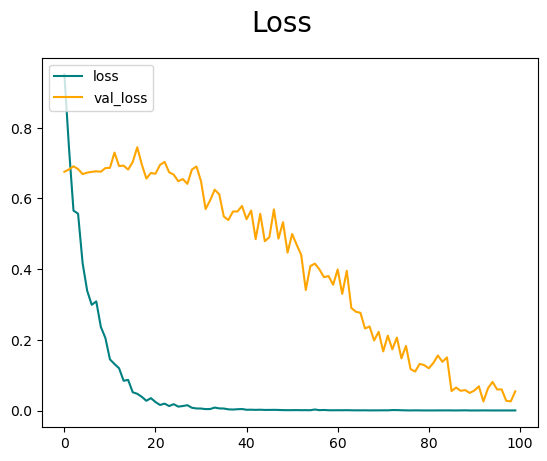

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

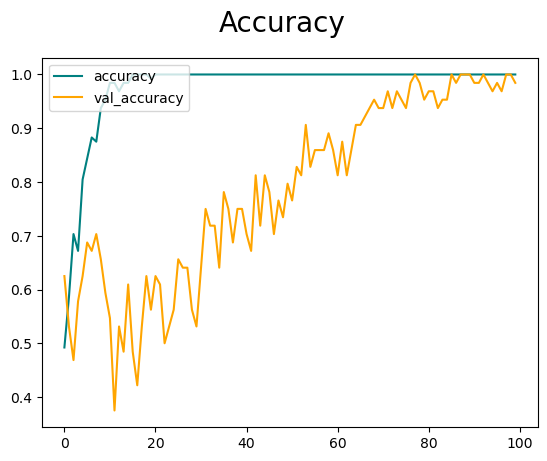

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### Evaluation

In [19]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [20]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [21]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2022-12-25 20:51:30.410585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 255ms/step


In [22]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


#### Save and Inference the Model in Keras format

In [23]:
# Save trained model in keras (.h5)
from tensorflow.keras.models import load_model
model.save(os.path.join('models','imageclassifier.h5'))

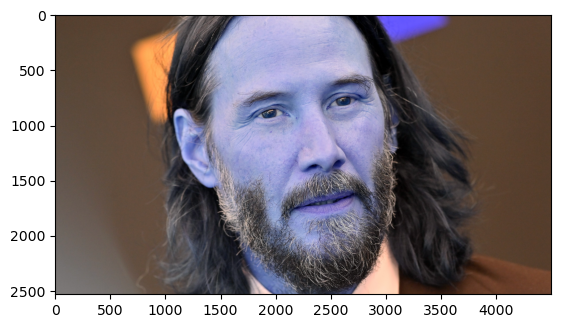

In [34]:
import cv2
img = cv2.imread('wick.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(img)
plt.show()

In [35]:
# Inference the Keras model
new_model = load_model('./models/imageclassifier.h5')
trt_outputs = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 104ms/step


In [36]:
print(trt_outputs[0][0])
if trt_outputs[0][0] > 0.5: 
    print(f'Predicted class is Wick')
else:
    print(f'Predicted class is Rambo')

0.99955255
Predicted class is Wick


#### Save the Model in PB format and Convert it into ONNX

In [37]:
# Save model in the saved_model format
SAVED_MODEL_DIR="./models/native_saved_model/"
model.save(SAVED_MODEL_DIR)

INFO:tensorflow:Assets written to: ./models/native_saved_model/assets


INFO:tensorflow:Assets written to: ./models/native_saved_model/assets


In [38]:
# Convert trained model into ONNX
!python -m tf2onnx.convert --saved-model "./models/native_saved_model" --output model.onnx --opset 11 --verbose

2022-12-25 20:56:29.736242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/seyedalicheraghi/miniconda3/envs/tfe/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-12-25 20:56:33,364 - WARNING - tf2onnx.tf_loader: '--tag' not specified for saved_model. Using --tag serve
2022-12-25 20:56:33,886 - INFO - tf2onnx.tf_loader: Signatures found in model: [serving_default].
2022-12-25 20:56:33,886 - WARNING - tf2onnx.tf_loader: '--signature_def' not specified, using first signature: serving_default
2022-12-25 20:56:33,886 - INFO - tf2onnx.tf